In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Basic functions

In [2]:
# Cell with the functions

a1, a2, b1, b2 = 0.1, 0.1, 0.1, 0.12

def explicit_euler_calculation(x, times, h, sigma1, sigma2, I = None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = x[0] + (b1 - a1*x[1])*x[0]*h + sigma1*x[0]*I[0]
    x_current[1] = x[1] + (b2 - a2*x[0])*x[1]*h + sigma2*x[1]*I[1]   

    return x_current

def patankar_euler_calculation(x, times, h, sigma1, sigma2, I = None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = (x[0] + b1*x[0]*h + sigma1*x[0]*I[0]) / (1 + a1*x[1]*h)
    x_current[1] = (x[1] + b2*x[1]*h + sigma2*x[1]*I[1]) / (1 + a2*x[0]*h)
    return x_current

def stochastic_patankar_euler_calculation(x, times, h, sigma1, sigma2, I= None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = (x[0] + b1*x[0]*h) / (1 + a1*x[1]*h - sigma1*I[0] + (sigma1*I[0])**2)
    x_current[1] = (x[1] + b2*x[1]*h) / (1 + a2*x[0]*h - sigma2*I[1] + (sigma2*I[1])**2)
    return x_current


### Methods 

In [3]:
def explicit_euler_method(times, h, sigma1, sigma2, initial_cond, I = None ):
    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]

        if I is None:
            eec = explicit_euler_calculation(x_current, time, h, sigma1, sigma2)
        else :
            eec = explicit_euler_calculation(x_current, time, h, sigma1, sigma2, I[i-1])

        for j in range(2):
                x[i, j] = eec[j]
        x_current = x[i]

    return x


def stochastic_patankar_method(times, h, sigma1, sigma2, initial_cond, I = None ):
    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]
        
        spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i-1])

        for j in range(2):
                x[i, j] = spec[j]
        x_current = x[i]

    return x


def composite_euler_method(times, h, sigma1, sigma2, initial_cond, I = None ):
    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]
        
        pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i-1])
        spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i-1])

        for j in range(2):
            if pec[j] > 0:
                x[i, j] = pec[j]
            else:
                x[i, j] = spec[j]
        x_current = x[i]

    return x


def fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond, I = None):

    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]

        if I is None:
            eec = explicit_euler_calculation(x_current, time, h, sigma1, sigma2)
            pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2)
            spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2)
        else: 
            eec = explicit_euler_calculation(x_current, time, h, sigma1, sigma2, I[i-1])
            pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i-1])
            spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i-1])

        for j in range(2):
            if eec[j] > 0:
                x[i, j] = eec[j]
            elif pec[j] > 0:
                x[i, j] = pec[j]
            else:
                x[i, j] = spec[j]
        x_current = x[i]

    return x

### Secondary functions

In [4]:
def wierner_increments(matrix, step):

    num_rows, num_cols = matrix.shape
    aggregated_rows = num_rows // step
    remainder = num_rows % step

    result = np.zeros((aggregated_rows + (1 if remainder > 0 else 0), num_cols))

    for i in range(aggregated_rows):
        result[i] = np.sum(matrix[i*step:(i+1)*step], axis=0)
    
    if remainder > 0:
        result[-1] = np.sum(matrix[aggregated_rows*step:], axis=0)
    
    return result

def simulate_system(times, h, sigma1, sigma2, initial_cond, I=None, sim = 'fully'):
    steps = len(times)
    
    # Generate shared random values if not provided
    if I is None:
        I = np.random.normal(0, np.sqrt(h), (steps, 2))
    
    if sim == 'fully':
        x = fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond, I)
    elif sim == 'composite':
        x = composite_euler_method(times, h, sigma1, sigma2, initial_cond, I)
    elif sim == 'explicit':
        x = explicit_euler_method(times, h, sigma1, sigma2, initial_cond , I)
    else:
        x = stochastic_patankar_method(times, h, sigma1, sigma2, initial_cond, I)

    return x, I

def generate_and_see(initial_time = 0, final_time = 100, h = 1/(2**4), sigma1 = 0.2, sigma2 = 0.2 , initial_conditions = [6,6] 
                     , sim = 'fully'):
    times  = np.arange(initial_time, final_time, h)
    x, _ = simulate_system(times, h, sigma1, sigma2, [6,6] , sim = 'fully')

    plt.plot(times, x[:, 0], label = 'x1')
    plt.plot(times, x[:, 1], label = 'x2')
    plt.legend()
    plt.show()
    return x

### Tests and results

##### The graph overlapped
Now I'm going to test if the functions are working, and I will test overlapping the graphs as we have in the article

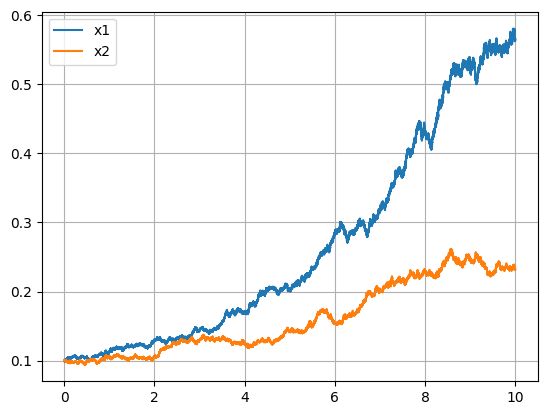

In [37]:
h = 1/(2**14)
times = np.arange(0,10 ,h)
x, I = simulate_system(times, h, 0.1, 0.1, [0.1, 0.1] , sim = 'fully')

plt.plot(times, x[:, 0], label = 'x1')
plt.plot(times, x[:, 1], label = 'x2')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
h_coarse = 1/(2**4)
times_coarse = np.arange(0,10 ,h_coarse)
y = fully_composite_euler_method(times_coarse, h_coarse, 0.1, 0.1, 
                                 [0.5, 0.5], wierner_increments(I, 2**10))


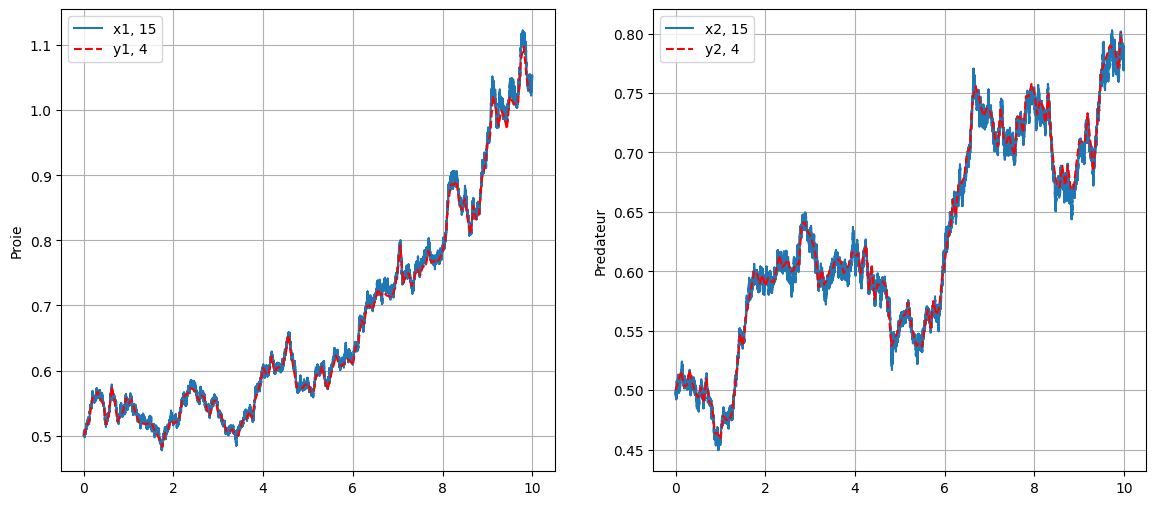

In [19]:
fig, ax = plt.subplots(1,2, figsize = (14,6))

ax[0].plot(times, x[:, 0], label = 'x1, 15')
ax[0].plot(times_coarse, y[:, 0], label = 'y1, 4', color = 'red', linestyle = '--')
ax[0].set_ylabel('Proie')

ax[1].plot(times, x[:, 1], label = 'x2, 15')
ax[1].plot(times_coarse, y[:, 1], label = 'y2, 4', color = 'red', linestyle= '--')
ax[1].set_ylabel('Predateur')

ax[0].legend()
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)


In [ ]:
stepsizes = [1/(2**i) for i in range(10, 3, -1)] 

for i in range(10,3,-1):

    h_coarse = 1/(2**i)
    times_coarse = np.arange(0,10 ,h_coarse)
    y = fully_composite_euler_method(times_coarse, h_coarse, 0.1, 0.1, 
                                 [0.5,0.5], wierner_increments(I, 2**(14-i)))
    fig, ax = plt.subplots(1,2 , figsize = (15,6))

    ax[0].plot(times, x[:, 0] , label = 'solution')
    ax[0].plot(times_coarse , y[:, 0], color = 'red',  label = f'x1 , 2**{-i}', linestyle = '--')

    ax[1].plot(times, x[:, 1] , label = 'solution')
    ax[1].plot(times_coarse , y[:, 1], color = 'red',  label = f'x1 , 2**{-i}',linestyle = '--')

    ax[0].set_ylabel('Proie')
    ax[1].set_ylabel('Predateur')
    
    ax[0].legend()
    ax[1].legend()

    ax[0].grid(True)
    ax[1].grid(True)    


##### Making the graph of the error 

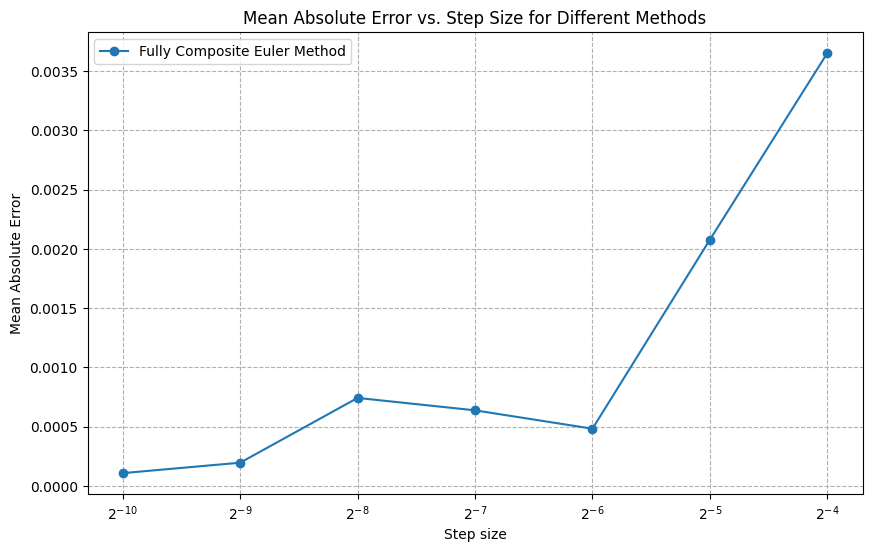

In [22]:
errors_fully_composite = []
for i in range(10,3,-1):

    h_coarse = 1/(2**i)
    times_coarse = np.arange(0,10 ,h_coarse)
    y = fully_composite_euler_method(times_coarse, h_coarse, 0.1, 0.1, [0.5, 0.5] , wierner_increments(I, 2**(14-i)))
    
    errors_fully_composite.append( np.mean( abs( y - x[::2**(14-i)])))
    


plt.figure(figsize=(10, 6))
plt.xscale('log', base =2) 
plt.plot(stepsizes, errors_fully_composite, label='Fully Composite Euler Method', marker='o')
#plt.plot(stepsizes, errors_composite_euler, label='Composite Euler Method', marker='x')
#plt.plot(stepsizes, errors_stoch_patankar, label='Stochastic Patankar Euler Method', marker='^')
plt.xlabel('Step size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Step Size for Different Methods')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

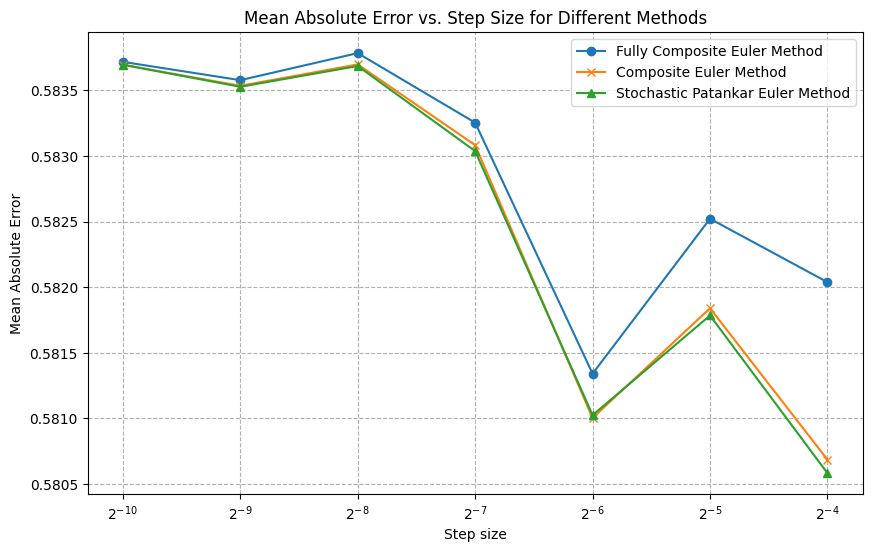

In [38]:

# Define the stepsizes and initialize the error storage
stepsizes = [1/(2**i) for i in range(10, 3, -1)]  # From 2^-10 to 2^-4
errors_fully_composite = []
errors_composite_euler = []
errors_stoch_patankar = []

# Reference solution from fine stepsize
reference_solution = x  # Results from the fine stepsize 1/(2**12)
times_fine = times

sigma1, sigma2 = 0.1, 0.1
initial_conditions = [0.5,0.5]

def calculate_mae(simulation, reference):
    # Mean Absolute Error calculation
    return np.mean(abs(simulation - reference))

# Iterate over each coarser stepsize
for h in stepsizes:
    step_ratio = int(h*(2**14))
    
    adjusted_random_values = wierner_increments(I, step_ratio)

    results_fully_composite, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'fully')
    errors_fully_composite.append(calculate_mae(results_fully_composite, reference_solution[::step_ratio]))

    results_composite_euler, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'composite')
    errors_composite_euler.append(calculate_mae(results_composite_euler, reference_solution[::step_ratio]))
    
    results_stoch_patankar, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'stoch')
    errors_stoch_patankar.append(calculate_mae(results_stoch_patankar, reference_solution[::step_ratio]))

# Plotting
plt.figure(figsize=(10, 6))
plt.xscale('log', base =2)
plt.plot(stepsizes, errors_fully_composite, label='Fully Composite Euler Method', marker='o')
plt.plot(stepsizes, errors_composite_euler, label='Composite Euler Method', marker='x')
plt.plot(stepsizes, errors_stoch_patankar, label='Stochastic Patankar Euler Method', marker='^')
plt.xlabel('Step size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Step Size for Different Methods')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


##### Calcul de error aleatoire, pour vérifier des differents graphiques

In [ ]:
sigma1, sigma2 = 0.4 , 0.4
initial_conditions = [6 , 6]

h1 = 1/(2**20)
times = np.arange(0,10 ,h1)
x, I = simulate_system(times, h1, sigma1, sigma2, initial_conditions , sim = 'fully')



# Define the stepsizes and initialize the error storage
stepsizes = [1/(2**i) for i in range(10, 3, -1)]  # From 2^-10 to 2^-4
errors_fully_composite = []
errors_composite_euler = []
errors_stoch_patankar = []

# Reference solution from fine stepsize
reference_solution = x  # Results from the fine stepsize 1/(2**12)
times_fine = times



def calculate_mae(simulation, reference):
    # Mean Absolute Error calculation
    return np.mean(abs(simulation - reference))

# Iterate over each coarser stepsize
for h in stepsizes:
    step_ratio = int(h*(2**20))
    
    adjusted_random_values = wierner_increments(I, step_ratio)

    results_fully_composite, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'fully')
    errors_fully_composite.append(calculate_mae(results_fully_composite, reference_solution[::step_ratio]))

    results_composite_euler, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'composite')
    errors_composite_euler.append(calculate_mae(results_composite_euler, reference_solution[::step_ratio]))
    
    results_stoch_patankar, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'stoch')
    errors_stoch_patankar.append(calculate_mae(results_stoch_patankar, reference_solution[::step_ratio]))

# Plotting
plt.figure(figsize=(10, 6))
plt.xscale('log', base =2)
plt.plot(stepsizes, errors_fully_composite, label='Fully Composite Euler Method', marker='o')
plt.plot(stepsizes, errors_composite_euler, label='Composite Euler Method', marker='x')
plt.plot(stepsizes, errors_stoch_patankar, label='Stochastic Patankar Euler Method', marker='^')
plt.xlabel('Step size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Step Size for Different Methods')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

##### Trying to do the table 

In [136]:
import numpy as np


def simulate_system_table(num_simulations, sigma1, sigma2, h, initial_conditions):
    times = np.arange(0, 10, h)  # simulate from t=0 to t=10
    total_simulations_with_negatives = 0
    steps_per_negative_simulation = []

    for _ in range(num_simulations):
        result = fully_composite_euler_method(times, h, sigma1, sigma2, initial_conditions)
        negative_steps = np.sum(np.any(result < 0, axis=1))  # Count steps with any negatives in each row
        if negative_steps > 0:
            steps_per_negative_simulation.append(negative_steps)
            total_simulations_with_negatives += 1

    if total_simulations_with_negatives > 0:
        average_negative_steps = np.sum(steps_per_negative_simulation)/(100/h)
    else:
        average_negative_steps = 0

    return average_negative_steps, total_simulations_with_negatives

# Example parameters
sigma1 = 0.8
sigma2 = 0.8
stepsize = 1/(2**4)
num_simulations = 1000
initial_conditions = [0.5, 0.5]  

average_steps, negative_count = simulate_system_table(num_simulations, sigma1, sigma2, stepsize, initial_conditions)
print(f"Average number of negative steps per simulation: {average_steps}")
print(f"Number of simulations with negative values: {negative_count}")


Average number of negative steps per simulation: 0
Number of simulations with negative values: 0


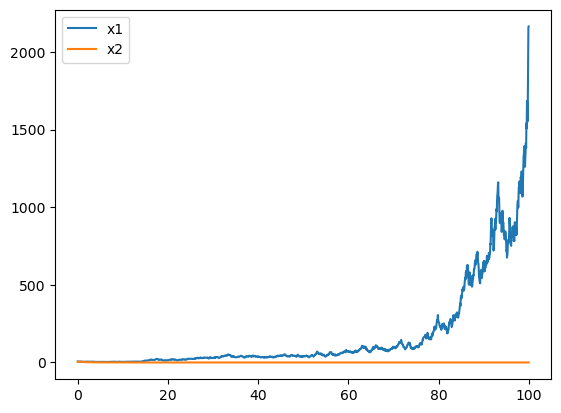

0


In [434]:
value = generate_and_see(0, 100, h = 1/16, sigma1 = 0.2, sigma2 = 0.2, initial_conditions= [6,6], sim = 'explicit')
print(np.sum(np.any(value < 0, axis = 1 )))

##### Verifying the direction of the noises in low values for steps

In [ ]:
generate_and_see(initial_time = 0, final_time = 1)

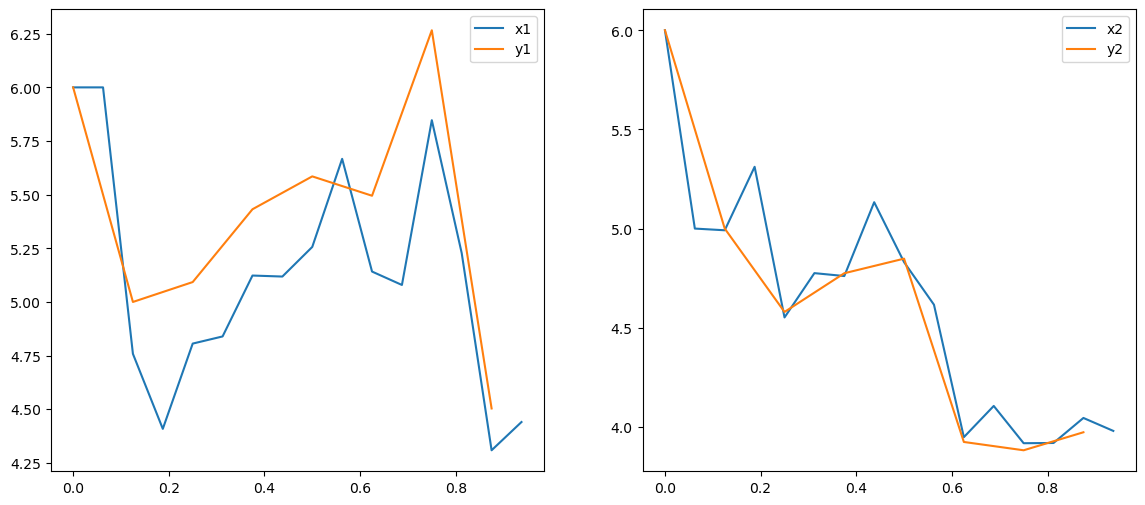

In [497]:
h_fine = 1/(2**4)
times_fine = np.arange(0,1 ,h_fine)
result_fine, I_fine = simulate_system(times_fine, h_fine, 0.5, 0.5, [6,6] , sim = 'fully')

h_coarse = 1/(2**3)
times_coarse = np.arange(0,1, h_coarse)
result_coarse, _ = simulate_system(times_coarse, h_coarse, 0.5, 0.5, [6,6] ,wierner_increments(I_fine, 2), sim = 'fully')

fig, ax = plt.subplots(1,2, figsize = (14,6))

ax[0].plot( times_fine, result_fine[:, 0 ], label = 'x1')
ax[0].plot( times_coarse, result_coarse[:, 0 ], label = 'y1')

ax[1].plot( times_fine, result_fine[:, 1], label= 'x2')
ax[1].plot( times_coarse, result_coarse[:, 1], label= 'y2')

ax[0].legend()
ax[1].legend()


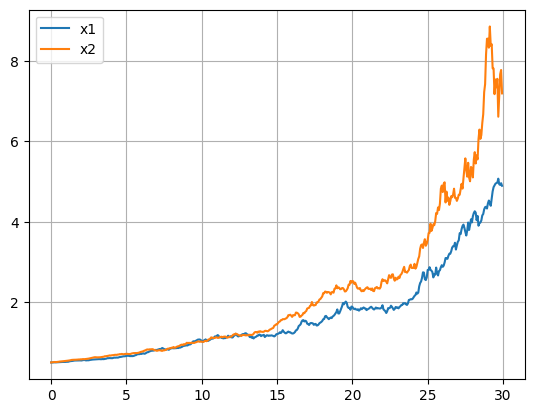

1000


In [12]:
simulations = []
y = 0

h = 1/(2**4)
times = np.arange(0, 30, h)
sigma1, sigma2 = 0.5 , 0.5
initial_cond = [0.5,0.5]

for i in range(1000):
    x = fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond, I = None)
    simulations.append(x)

for j in range(len(simulations)):
    y += simulations[j]

y = y / len(simulations)

plt.plot(times, y[:, 0], label = 'x1')
plt.plot(times, y[: ,1], label = 'x2')
plt.legend()
plt.grid(True)
plt.show()

print(len(simulations))

C:\Users\jhony\AppData\Local\Temp\ipykernel_14356\69841779.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


1000


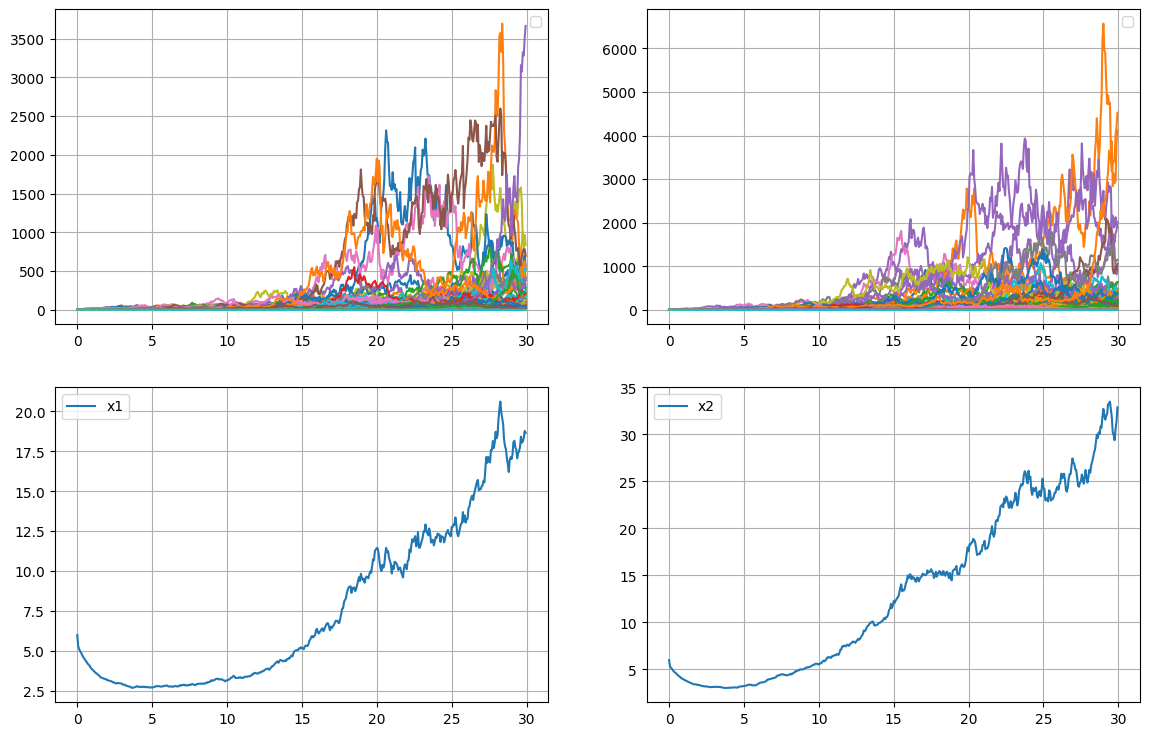

In [61]:
simulations = []
y = 0

h = 1/(2**4)
times = np.arange(0, 30, h)
sigma1, sigma2 = 0.5 , 0.5
initial_cond = [6,6]

fig, ax = plt.subplots(2,2, figsize = (14, 9))

for i in range(1000):
    x = fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond= initial_cond, I = None)
    ax[0][0].plot(times, x[:, 0])
    ax[0][1].plot(times, x[: ,1])
    
    simulations.append(x)

for j in range(len(simulations)):
    y += simulations[j]

y = y / len(simulations)

ax[1][0].plot(times, y[:, 0], label = 'x1')
ax[1][1].plot(times, y[: ,1], label = 'x2')

for axs in ax.flat:
    axs.legend()
    axs.grid(True)

print(len(simulations))

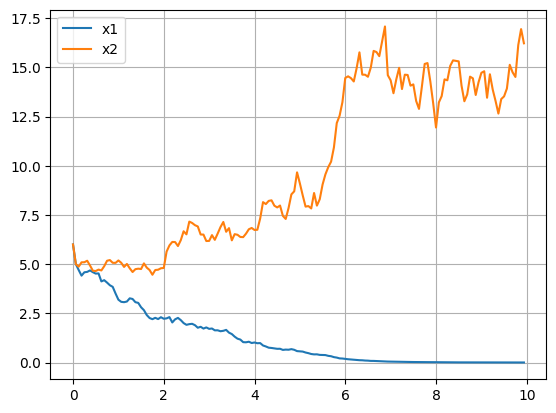

In [47]:
h = 1/(2**4)
times = np.arange(0,10 ,h)
x, I = simulate_system(times, h, 0.2, 0.2, [6, 6] , sim = 'fully')

plt.plot(times, x[:, 0], label = 'x1')
plt.plot(times, x[:, 1], label = 'x2')
plt.legend()
plt.grid(True)
plt.show()